# Pythonopdracht week 6: CNN

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Images-from-Data-Set" data-toc-modified-id="Loading-Images-from-Data-Set-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Images from Data Set</a></span></li><li><span><a href="#Define-a-Convolutional-Neural-Network" data-toc-modified-id="Define-a-Convolutional-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define a Convolutional Neural Network</a></span></li><li><span><a href="#Training-the-Network" data-toc-modified-id="Training-the-Network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training the Network</a></span></li><li><span><a href="#Testing-the-Network" data-toc-modified-id="Testing-the-Network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing the Network</a></span></li><li><span><a href="#Improving-the-Network" data-toc-modified-id="Improving-the-Network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Improving the Network</a></span></li></ul></div>

**For this notebook, you will both answer questions and do some programming. Please write answes in green in the given Answer cells. Please write code where instructed.**

This notebook is an adaptation of a demo notebook in the Pytorch documentation. Please be patient while running the code in the notebook. I haven't used any GPU that might be available on your computer. Training two epochs on my computer takes more than a minute (yes not too fast...).

In order to run the code you need to install pytorch on your system. The modules `torch` and `torchvision` should be installed. See the [PyTorch](https://pytorch.org/) website how to install Pytorch on your machine.

The [PyTorch](https://pytorch.org/) website is invaluable for understanding the code in this notebook. And it is a great source for further exploration of modern Machine Learning.

In [110]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [111]:
device = None;
# device = torch.device('cpu') # uncomment this line to explicitly set the device
if device == None:
    if torch.cuda.is_available():
        print("CUDA used")
        device = torch.device('cuda')
    else:
        print("CPU used")
        device = torch.device('cpu')

CPU used


## Loading Images from the Data Set

PyTorch has some well known data sets 'build in', among others the CIFAR data set. In the code below we download (if needed) and read in the data set. In the process of defining the train and test set PyTorch allows us to transform the images on the fly. In this case we only convert the image to a tensor (the basic PyTorch data structure comparable with the ndarray in numpy) and we normalize the image (by subtracting 0.5 from each rgb value in the image and dividing by 0.5, as each image has rgb values in the range from 0 to 1 we end up with values in the range from -1 to +1). Normalization of the data is important in any neural network.

PyTorch loads a dataset into separate train and test sets. First we define the trainset.

In [112]:
# Uncomment the following lines if you get a SSL certificate error to disable the verification.
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context (edited)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


The trainset has an attribute ``data`` that contains the entire datamatrix in a numpy array.

In [113]:
trainset.data.shape

(50000, 32, 32, 3)

i.e. 50000 images of 32x32 pixels each with an R, G and B value.

Also the labels are encoded in a simple Python list

In [114]:
len(trainset.targets)

50000

The target values are indices from 0 to 9 and the corresponding class names are encoded in the following list:

In [115]:
classnames = trainset.classes
print(classnames)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In pure Python/Numpy we can now display one of the images with the target class name as title for the plot:

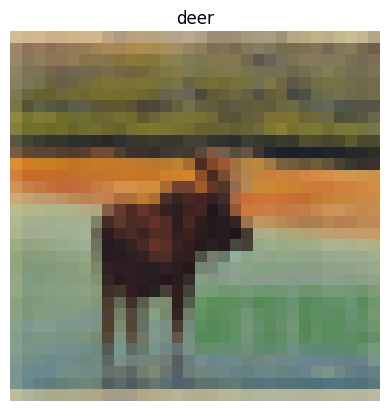

In [116]:
i = 66
plt.imshow(trainset.data[i])
plt.axis('off')
plt.title(classnames[trainset.targets[i]]);

Later on we will define a ``DataLoader`` that makes it easy to load a small number of (image, target) tuples (a batch) needed in one gradient descent step in the stochastic gradient learning process. While loading the data the data in the dataset is transformed on the fly. For this dataset two transforms are used in sequence. First the ``ToTensor`` transform that takes an HxWxC (with C=3) numpy array into a PyTorch tensor of shape CxHxW which is the standard for encoding color images in deep learning. The second transform in the sequence is a normalization (see the PyTorch documentation for ``torchvision.transforms.Normalize``).

<span style="color:red">**Question 1.1**</span>.

Given the normalization ``Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`` and an original color value (r,g,b) what is the normalized color value (r',g',b')? What do all those values 0.5 represent?

<span style="color:Green">
    
**Answer**

If we take rewrite ``Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`` as ``Normalize((m_1, m_2, m_3), (std_1, std_2, std_3))`` then the values 0.5 represent the following:

$r' = \frac{r - m_1}{std_1}$

$g' = \frac{g - m_2}{std_2}$

$b' = \frac{b - m_3}{std_3}$

</span>

In the same way we define and load the testset:

In [117]:
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

Then we define a DataLoader for both the train and testset. When defining a DataLoader we have to give the `batch_size` as argument for the class constructor. A DataLoader, being a Python iterable, makes it possible to retrieve batch_size arbitrary images from the data set.

In [118]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

## Displaying Tensor Images

For displaying 'tensor images' we provide two helper functions:

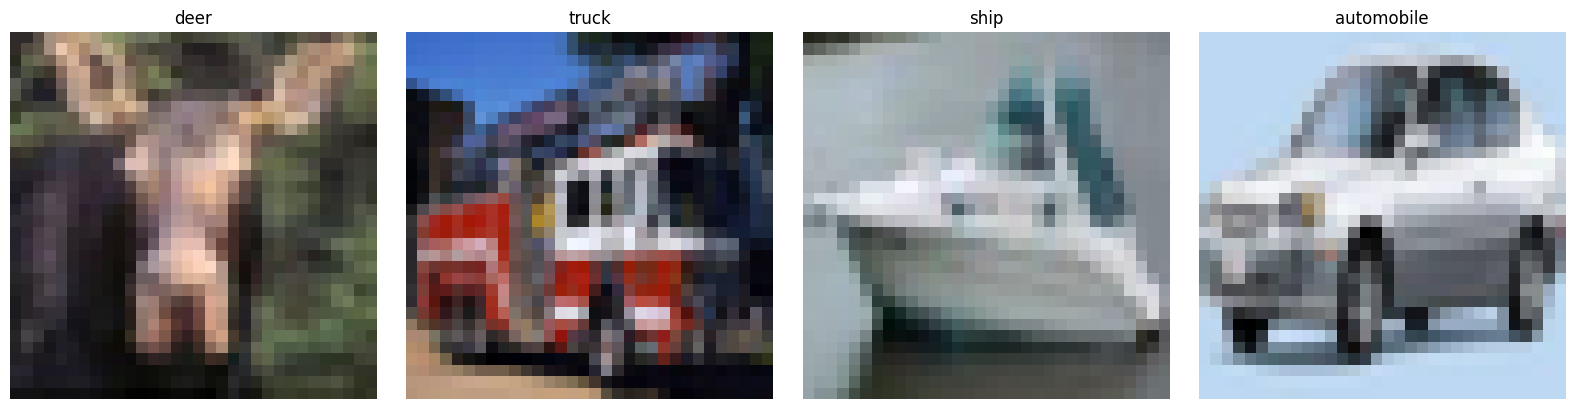

In [119]:
def imshow(img, ax=None):
    """imshow for Tensor Images obtained with a DataLoader
    from a data set. The images are of shape (3,M,N)
    and are in the range from -1 to +1"""
    img = (img - img.min()) / (img.max()-img.min())     # unnormalize
    npimg = img.numpy()
    if ax==None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))

def imtable(imgs, titles, ncols, hsize=4, vsize=4):
    nrows = int(np.ceil(len(imgs)/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*hsize, nrows*vsize))
    r, c = 0, 0
    for i, (im, label) in enumerate(zip(imgs, titles)):
        if nrows==1:
            ax = axs[c]
        elif ncols==1:
            ax = axs[r]
        else:
            ax = axs[r,c]
        imshow(im, ax=ax)
        ax.set_title(titles[i])
        ax.axis('off')
        c += 1
        if c == ncols:
            r += 1
            c = 0
    plt.tight_layout()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imtable(images, [classnames[i] for i in labels], 4)


In [120]:
for i in range(10):
    print(len([x for x in trainset.targets if x == i]))

5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


<span style="color:red">**Question 1.2**</span>.

If you would be random guessing the class of an image what would be the expected accuracy of the 'classifier'?

<span style="color:Green">
    
**Answer**

Considering that each class is equally represented, as can be seen above, a random guess has a 10% chance of being correct, so the expected accuracy of the 'classifier' would be 0.1
    
</span>

## Define a Convolutional Neural Network

We define the following CNN to classify the CIFAR images. Observe that first the functional processing blocks in the CNN are instantiated in the ``__init__`` function and then used in the ``forward`` method implementing the forward pass from input to output of the network.

The backpropagation pass to calculate the derivatives of the loss with respect to the data throughout the network is automagically done by PyTorch. Only when you as a programmer introduce new functional processing blocks you have to implement the backward pass yourself.

In [121]:
class Net(nn.Module):
    def __init__(self, verbose=0):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.verbose = verbose

    def forward(self, x):
        # Note in the forward pass we have 'numbered'
        # the x's just to make it easier to collect
        # the code to print information about the network
        # further on in the code.
        x1a = self.conv1(x)
        x1 = self.pool1(F.relu(x1a))
        x2 = self.pool2(F.relu(self.conv2(x1)))
        x3 = torch.flatten(x2, 1) # flatten all dimensions except batch
        x4 = F.relu(self.fc1(x3))
        x5 = F.relu(self.fc2(x4))
        x6 = self.fc3(x5)

        if self.verbose:
            # Write the code to print the properties of the
            # different stages in the CNN
            # Your code here
            self.verbose -= 1

        return x6

# with verbose=1 the 'debugging' code is printed only once
# while running the forward pass multiple times.
net = Net(verbose=1).to(device=device)

Given the class definition for a network we can print an instantiation of that class to obtain an overview of the functional processing blocks that are defined. Note that the ``relu`` and ``flatten`` functions are not printed (but they are in the flow of processing blocks).

In [122]:
print(net)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Note that the shapes of the data that is processed at all layers in the network is not printed. That is where we need 'your code' in the ``Net`` class.

The code below sets the verbose attribute of the ``Net`` instantiation to 1 and then feeds it a batch of images. The output is printed, which is not needed of course as it will be total nonsense as nothing is learned yet.

It should be noted that PyTorch automagically takes care of proper initialization of the parameters of each of the processing modules in the network. If you want to you can override the default initialization (read the docs for that).

In [123]:
net.verbose=1 # when you run it you should set this to 1
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
outputs = net(images)
print(outputs)

tensor([[-0.0925, -0.0540,  0.0538, -0.0648, -0.1146, -0.0763,  0.0655, -0.0113,
         -0.0425,  0.0016],
        [-0.0935, -0.0563,  0.0516, -0.0840, -0.1216, -0.0780,  0.0664, -0.0045,
         -0.0385,  0.0076],
        [-0.0900, -0.0615,  0.0374, -0.0877, -0.1105, -0.0851,  0.0606, -0.0179,
         -0.0331,  0.0088],
        [-0.0983, -0.0576,  0.0467, -0.0865, -0.1303, -0.0734,  0.0692, -0.0032,
         -0.0424, -0.0003]], grad_fn=<AddmmBackward0>)


With the printed information you ought to be able to answer the following questions:

In a data graph the first part of this network looks like
<img src="https://rvdboomgaard.github.io/ComputerVision_LectureNotes/_static/cifar_cnn_incomplete.png"
     width=80%
     alt="data flow graph"
     style="float: center;" />

The CIFAR images are 32x32 color images, so $W_1 = H_1 = 32$ and $C_1 = 3$. 

Observe that in this common way to depict a CNN the blocks that are drawn corresponds with the data, the arrows correspond with the data processing modules. E.g. the first arrow corresponds with the sequence Conv1 --> ReLU --> Maxpool modules. 

The last data block in this CNN is a vector of 10 elements where each element equals the activation for one of the 10 classes. This last layer is obtained with a fully connected neural network from the layer before that which is also a vector but with 84 elements.

Note that if you want to know what the data shape is after just the first or second convolution you have to change the code in the ``forward`` method.

<span style="color:red">**Question 2.1**</span>

If you print the shape of tensor ``x`` in the ``forward`` method you will get ``torch.Size([4, 3, 32, 32])``. Why is the first dimension of size 4 in this tensor? Note that this size is NOT depicted in the above graph!

<span style="color:Green">
    
**Answer**

This first dimension of size 4 is the batch size.
    
</span>

<span style="color:red">**Question 2.2**</span>

What is the shape of the tensor that results from ``conv1(x)``? What does it tell you about the convolution/correlation algorithm that is used? To find this experimentally you have to change the code in the ``forward`` method.

<span style="color:Green">
    
**Answer**

The shape we get is ``torch.Size([4, 10, 28, 28])``, this shows us that the convolution algorithm used does not use padding around the edges, which means that, due to our $5 \times 5$ convolution, pixels in the 2 edge layers will be discarded (although they still live on in those pixels that used their information in the convolution layer).
    
</span>

<span style="color:red">**Question 2.3**</span>

Complete the data graph. For each of data block (image blocks at the start and flattened arrays at the end) you should indicate the shape of the block. The blocks correspond with the tensors `x`, `x1` ... `x6` in the `forward` method. Either you should look into the documentation of the processing modules that are being used in the `__init__` function or you should run the code and print the shapes (when we are running/training the network).

<span style="color:Green">
    
$C_1 = 3, H_1 = 32, W_1 = 32$

$\downarrow$ ``pool1`` $\circ$ ``conv1``

$C_2 = 10, H_2 = 14, W_2 = 14$

$\downarrow$ ``pool2`` $\circ$ ``conv2``

$C_3 = 16, H_3 = 5, W_3 = 5$

$\downarrow$

$C_4 = 1, H_4 = 400, W_4 = 1$

$\downarrow$ ``fc1``

$C_5 = 1, H_5 = 120, W_5 = 1$

$\downarrow$  ``fc2``

$C_6 = 1, H_6 = 84, W_6 = 1$

$\downarrow$ ``fc3``

$C_7 = 1, H_7 = 10, W_7 = 1$
    
    
</span>

<span style="color:red">**Question 2.4**</span>

In the `__init__` function the following processing modules are defined: `conv1`, `pool1`, `conv2`, `pool2`, `fc1`, `fc2` and `fc3`. Indicate where these modules are used in your data flow graph (i.e. you have to label the arrows in the graph with the (sequence of) operations associated with each arrow.

<span style="color:Green">
    
**Answer**

See the graph above
    
</span>

<span style="color:red">**Question 2.5**</span>

For each of processing modules `conv1`, `pool1`, `conv2`, `pool2`, `fc1`, `fc2` and `fc3` give the number of parameters that have to be learned (don't forget the bias parameters...)

<span style="color:Green">
    
**Answer**

``conv1``: $10$ filters of size $5 \times 5 \times 3$ with 1 bias parameter for each output layer results in $10 \cdot 5 \cdot 5 \cdot 3 + 10 = 760$ parameters.

``pool1``: Does not have any parameters

``conv2``: $16$ filters of size $5 \times 5 \times 10$ with 1 bias parameter for each output layer results in $16 \cdot 5 \cdot 5 \cdot 10 + 16 = 4016$ parameters.

``pool2``: Does not have any parameters

``fc1``: One weight parameter for each pair (input node, output node) and one bias parameter for each output node results in $400 * 120 + 120 = 48120$ parameters.

``fc2``: One weight parameter for each pair (input node, output node) and one bias parameter for each output node results in $120 * 84 + 84 = 10164$ parameters.

``fc3``: One weight parameter for each pair (input node, output node) and one bias parameter for each output node results in $84 * 10 + 10 = 850$ parameters.
    
</span>

**HINT**: The answer to question 2.5 can be computed by 'interrogating' the network. For instance for the `fc2` linear module we get:

The answer to the last question from the above cell can be computed by 'interrogating' the network. For instance for the `fc2` linear module we get:

In [124]:
for p in net.fc2.parameters():
    print(p.shape)

torch.Size([84, 120])
torch.Size([84])


So for this module there are two tensors defining the parameters. Note that an object of type `torch.Size` is not a tensor

<span style="color:red">**Question 2.6**</span>

What are these tensors? (please look back in your machine learning course notes).

<span style="color:Green">
    
**Answer**
These tensors are just N dimensional arrays, the PyTorch equivalent of Numpy's ndarray.
    
</span>

<span style="color:red">**Question 2.7**</span>

How many parameters in total for this `fc2` module?

<span style="color:Green">
    
**Answer**
As said above in 2.5, the ``fc2`` module has 10164 total parameters.
    
</span>

Below you have to write the code to calculate the total number of parameters to be learned in this network.

In [125]:
# Write the code to calculate the total number of parameters in the entire network
# Your code here
modules = [net.conv1, net.conv2, net.fc1, net.fc2, net.fc3]

parameters = 0
for module in modules:
    for p in module.parameters():
        current = 0
        for dimension in p.shape:
            if current == 0:
                current = dimension
            else:
                current *= dimension
        parameters += current
print(parameters)

63910


Later on in this notebook we revisit the interrogation of the network again to actually observe what parameter values are learned.

## Loss Function and Optimizer

To train the network we also need to define a loss function:

In [126]:
loss_criterion = nn.CrossEntropyLoss()

When the network is fed input the output is obtained with ``outputs = net(inputs)``, then the outputs are compared with the target values (labels in our case) with the `CrossEntropyLoss` function. Read the PyTorch documentation to learn why this loss is well suited for a classification problem (and why the softmax function is not needed in this network).

Observe that although the output of the network is a 10 element vector (activation for each of the different classes) the target value is an integer id for the target class. The conversion to one-hot-encoding is implicitly done within the loss function (see the source code).

We also need an optimizer. A standard optimizer is PyTorch is the SGD (Stochastic Gradient Descent) optimizer.

In [127]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, dampening=0)

here `lr` is the learning rate. The momentum is used in the gradient descent procedure to 'remember' in which direction the gradient descent is running and not deviate too easily from that direction.

<span style="color:red">**Question 2.8**</span>

Read the explanation of the SGD optimizer in the PyTorch documentation.
1. Why the name **stochastic** gradient descent?
2. What value for the ``momemtum`` and `dampening` should be chosen to get the classical gradient descent?

<span style="color:Green">
    
**Answer**

(1) Reguler gradient descent (GD) uses the actual gradient in each iteration of the algorithm. SGD optimizes this step of finding the gradient by approximating it with a subset of the dataset rather than using the entire dataset to compute it. This nature of approximation is why it is called **stochastic**.

(2) No matter what value you set momentum and dampening to, you won't get a regular gradient descent. As mentioned in (1) SGD only uses a subset of the dataset to approximate the gradient. Setting the value of momentum and damping won't change the nature of the approximation of the gradient.

</span>

## Training the Network

Training the network using a variant of the gradient descent algorithm boils down to:
1. feed a minibatch of examples to the network
2. run the forward pass, i.e. calculate the output through all its intermediate processing modules)
3. set all gradients (derivative of the loss with respect to all parameters) equal to zero
4. calculate the backward pass (to calculate all gradients
5. for each of the parameters make a step in the right direction and adapt the parameters accordingly.

This process is repeated until the minibatches have fed all examples in the training set to the learning algorithm. That completex one **epoch** in learning. Then this process is repeated until a specified number of epochs is done.

In the learning process we keep track of the loss on the learning set and the loss on the test set both of which are calculated after each epoch. To have some indication whether the network is learning during an epoch we also report the loss over the last batches fed to the netword for learning.

One epoch of learning is encaptured in the `train_loop` function

In [128]:
def train_loop(dataloader, model, loss_fn, optimizer, no_report=1000, device=None):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Move the data to GPU (if available)
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % no_report == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



While learning for several epochs we also calculate the performance on the test or validation set. This is encoded in the function `test_loop`.

In [129]:
def test_loop(dataloader, model, loss_fn, device=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The learning process then becomes:

In [130]:
%%timeit -n1 -r1
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, net, loss_criterion, optimizer, device=device)
    test_loop(testloader, net, loss_criterion, device=device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.270112  [    0/50000]
loss: 2.146391  [ 4000/50000]
loss: 2.660198  [ 8000/50000]
loss: 1.833568  [12000/50000]
loss: 2.243064  [16000/50000]
loss: 1.514862  [20000/50000]
loss: 1.834955  [24000/50000]
loss: 1.565153  [28000/50000]
loss: 0.750262  [32000/50000]
loss: 2.040930  [36000/50000]
loss: 1.038198  [40000/50000]
loss: 1.331811  [44000/50000]
loss: 1.377957  [48000/50000]
Test Error: 
 Accuracy: 49.9%, Avg loss: 1.366536 

Epoch 2
-------------------------------
loss: 1.760740  [    0/50000]
loss: 1.687489  [ 4000/50000]
loss: 1.016700  [ 8000/50000]
loss: 1.951549  [12000/50000]
loss: 1.679569  [16000/50000]
loss: 1.336725  [20000/50000]
loss: 1.578126  [24000/50000]
loss: 1.396402  [28000/50000]
loss: 0.706024  [32000/50000]
loss: 1.385653  [36000/50000]
loss: 1.517605  [40000/50000]
loss: 1.170409  [44000/50000]
loss: 1.757488  [48000/50000]
Test Error: 
 Accuracy: 52.9%, Avg loss: 1.327601 

Done!
2min ± 0 ns per loop (mean ± s

In [131]:
# Uncomment the following 2 lines to save your network to file
PATH = './cifar_net_100e.pth'
# torch.save(net.state_dict(), PATH)
#
# when saved you can load it back into memory with
# (again uncomment the following 2 lines)
# net = Net().to(device)
# net.load_state_dict(torch.load(PATH))

We load some images from the test set, display these image with their ground truth label. 

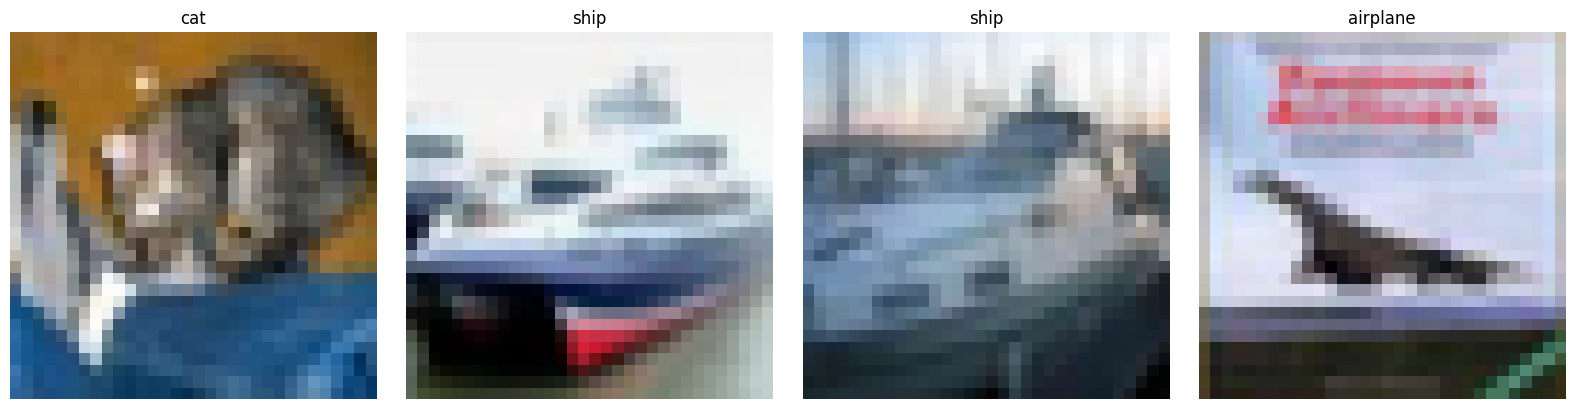

In [132]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imtable(images, [classnames[i] for i in labels], 4)

Then we run these image through the network and print the outputs of the 10 output nodes for all images. Note that now we are not training the network Pytorch doesn't need to keep track of all the intermediate outputs of all modules in the network (in preparation of a backward pass) and we can tell Pytorch not to do that with `no_grad()`.

While learning we didn't use the `softmax` function (see the PyTorch documentation) that normalizes the output for the 10 classes such that the a posteriori class probability if modeled (that would not be what the loss function expects). Now we are using the network in the feed forward mode only we will apply the softmax function.

In [133]:
with torch.no_grad():
    outputs = F.softmax(net(images.to(device)), dim=-1)
npoutputs = outputs.cpu().numpy()
print(npoutputs)

[[2.4699980e-02 6.8834741e-03 6.2818304e-02 5.0145680e-01 1.3426501e-02
  3.1592479e-01 2.6251476e-02 1.3796919e-02 2.7826859e-02 6.9148946e-03]
 [4.1334148e-02 8.2180902e-02 6.9335038e-05 5.3844142e-06 6.7753735e-06
  6.1510383e-07 4.7638709e-06 9.1469718e-07 8.7259644e-01 3.8008234e-03]
 [1.5593249e-01 3.1673551e-01 1.1429200e-02 3.4423461e-03 3.9884816e-03
  9.1258081e-04 2.2725367e-03 1.2847122e-03 4.3128425e-01 7.2717935e-02]
 [1.5564999e-01 5.1934738e-03 2.9839214e-03 6.7746929e-05 4.9740536e-04
  9.0321655e-06 6.0346461e-05 2.5895724e-05 8.3456457e-01 9.4774668e-04]]


The predicted label will be the label with the largest output value.

In [134]:
maxvalue, maxindex = torch.max(outputs, 1)
print('True     : ', ' '.join('%10s' % classnames[labels[j]]
                              for j in range(batch_size)))
print('Predicted: ', ' '.join('%10s' % classnames[maxindex[j]]
                              for j in range(batch_size)))

True     :         cat       ship       ship   airplane
Predicted:         cat       ship       ship       ship


For such a small set of test images we run into the possibility that the classification is very bad. Let's test the network more carefully.

## Inspecting the Network

In general it is really hard to understand what a (convolutional) neural network is doing. What do the learned weights represent? The answer to that question is still largely unknown. There are several papers that describe what particular nodes in the network are responsive to. These methods are beyond the scope of a bachelor course.

An exception is the first layer in a CNN. The convolutions there directly operate on the (color) image data and like we are used to in computer vision the convolution kernels (weigh functions) can be visualized as images themselves.

The hypothesis in developing CNN's was that local structure in images carries the spatial information needed to interpret the images. So when visualizing the kernels from the first convolution layer we hope to see the network has learned to respond to all sorts of local structure patterns.

These patterns are then in layers downwards in the datastream combined to recognize larger structures in images.

Your task is to visualize the kernels in the first convolution module `conv1` as small images.

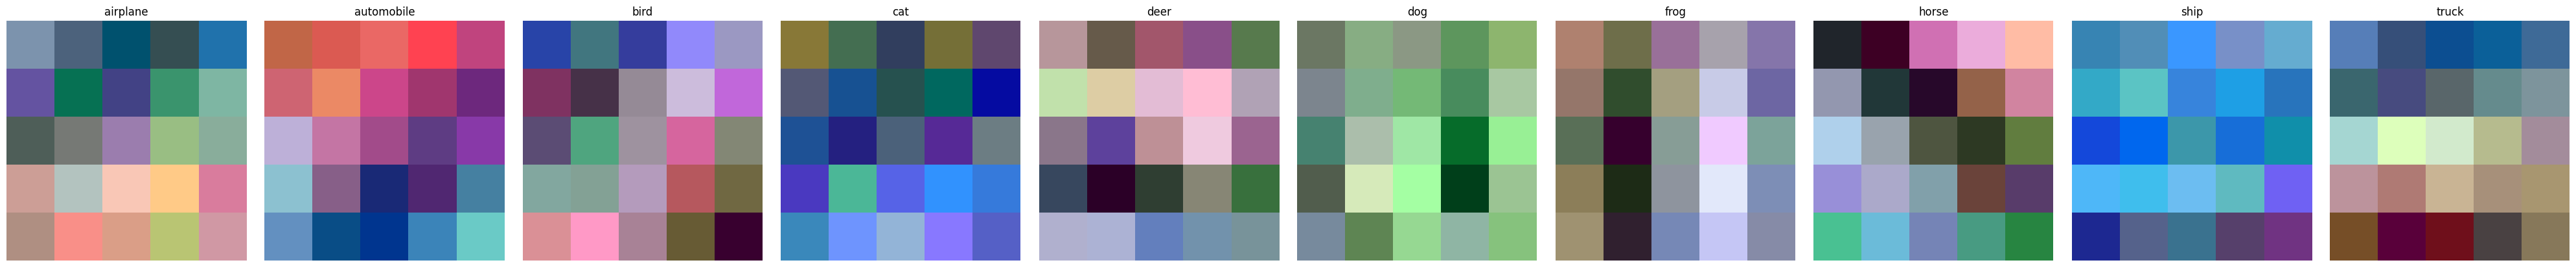

In [136]:
# Here the code to visualize the kernels
# Your code here

weights = net.conv1.weight.data
imtable(net.conv1.weight.data, classnames, 10)


## Improving the Network

Selecting a network architecture for a CNN is more of an art than a science. Simple experimenting with different number of channels, with different number of (convolution) layers can sometimes improve your network.

<span style="color:red">**Question 5.1**</span>

1. The obvious way to start improving your network is by training for more epochs. Only 2 epochs is really not much (but you need a fast computer or a GPU or a lot of patience). But you should be able to increase the number of epochs from 2 to 10 when you run the learning at night.

1. Change the number of channels in the first data (image) block after the input image (a block with 3 channels) from 10 to 20 and train and run the network again. Does it improve the performance? Again start with 2 epochs of learning.

1. Change the size of the convolution kernels in the `conv1` module from 5 to 3. Again start with 2 epochs of learning.

<span style="color:Green">
    
**Answer**

(1) While the trainging time was obviously significantly larger, the accuracy of the model also increase when increasing the epochs from 2 to 10. 

(2) The model took longer to train due an increase in parameters, but it did increase accuracy.

(3) The model less long to train, but it also decreased the accuracy of the model. This is likely due the kernel capturing less features. 
    
    
</span>

## Bonus Exercises

- The speed of learning can be dramaticall improved by moving the entire dataset to the gpu (in case you have enough RAM on the gpu). I had a hard time to achieve that. If you can find an elegant way without the need to rewrite the data loaders i would be very interested.

- When you can learn faster or have a faster machine or have more time you could learn for a lot of epochs (say 100) and then plot the loss and accuracy for both the train and test set as a function of the number of epochs. That may provide you with evidence that the network is overfitting and thus that some regularization techniques might be neededn. This is suggested by the webpages describing learning for the same dataset but then implemented in Keras/Tensorflow (see https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/). There the loss and accuracy as function of the number of epochs is shown as (in yellow the testset scores and in blue the trainset scores):
<img src="https://rvdboomgaard.github.io/ComputerVision_LectureNotes/_static/cifar_overfitting.png"
     width=50%
     alt="data flow graph"
     style="float: center;" />
The network used was very much like the one that has been used in this lab.

- In the above mentioned paper using Keras/Tensorflow the problem over overfitting was succesfully mitigated using DropOut's in the network. It would be nice to see if you can do the same for our network.